In [1]:
import sys
sys.path.append('/content')

In [3]:
!ls /content

augmentation_generator_batch_size.py  custom_transformers.py  sample_data


In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist
import torch
import torch.nn.functional as F
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
import torchvision
from torchvision import transforms as T
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.metrics import classification_report,  confusion_matrix, ConfusionMatrixDisplay
from custom_transformers import *
from augmentation_generator_batch_size import *

In [5]:
def seed_everything(seed: int=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(51)

In [6]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# Konwersja do RGB
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# One-hot
Y_train = to_categorical(Y_train.flatten())
Y_test = to_categorical(Y_test.flatten())

k = Y_train.shape[1]

print(f"X_train.shape: {X_train.shape} \nY_train.shape: {Y_train.shape} \nX_test.shape: {X_test.shape} \nY_test.shape: {Y_test.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train.shape: (60000, 28, 28, 3) 
Y_train.shape: (60000, 10) 
X_test.shape: (10000, 28, 28, 3) 
Y_test.shape: (10000, 10)


random squares, max_size_ratio = 0.05, max_number_of_squares = 10, label = 0.9999

In [ ]:
square_cutout = RandomSquaresCutout(max_size_ratio = 0.05, max_number_of_squares = 10)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor = square_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

In [ ]:
k = Y_train.shape[1]
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
  train_generator, validation_data=test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 538s 236ms/step - accuracy: 0.8165 - loss: 0.5575 - val_accuracy: 0.8854 - val_loss: 0.3124
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 531s 236ms/step - accuracy: 0.9045 - loss: 0.2646 - val_accuracy: 0.9071 - val_loss: 0.2456
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 533s 237ms/step - accuracy: 0.9194 - loss: 0.2184 - val_accuracy: 0.9020 - val_loss: 0.2707
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 524s 233ms/step - accuracy: 0.9303 - loss: 0.1856 - val_accuracy: 0.9134 - val_loss: 0.2389
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 525s 233ms/step - accuracy: 0.9417 - loss: 0.1597 - val_accuracy: 0.9229 - val_loss: 0.2240
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 529s 235ms/step - accuracy: 0.9507 - loss: 0.1354 - val_accuracy: 0.9291 - val_loss: 0.2157


In [ ]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step


              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1000
           1       1.00      0.98      0.99      1000
           2       0.89      0.89      0.89      1000
           3       0.88      0.96      0.92      1000
           4       0.89      0.90      0.89      1000
           5       0.98      0.99      0.99      1000
           6       0.85      0.72      0.78      1000
           7       0.96      0.98      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.99      0.95      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



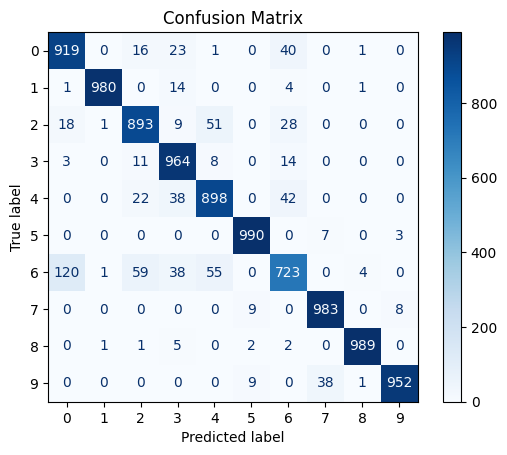

In [ ]:
print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Final Training Accuracy: 0.9501
Final Validation Accuracy: 0.9291


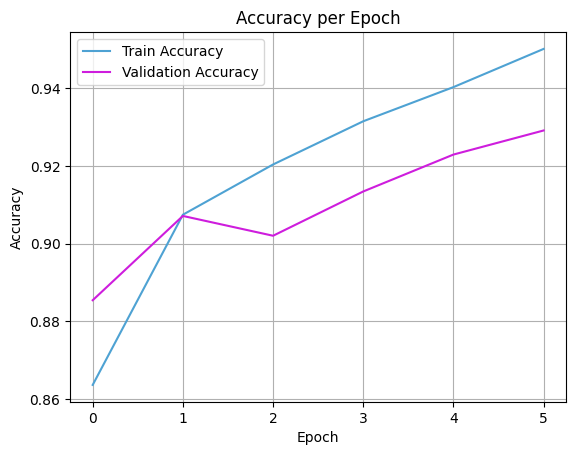

In [ ]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

random squares, max_size_ratio = 0.05, max_number_of_squares = 10, label = 0.999

In [7]:
square_cutout = RandomSquaresCutout(max_size_ratio = 0.05, max_number_of_squares = 10)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor = square_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True, soft_label_fraction=0.999)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

k = Y_train.shape[1]
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [8]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
  train_generator, validation_data=test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.8176 - loss: 0.5622 - val_accuracy: 0.8848 - val_loss: 0.3144
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9056 - loss: 0.2602 - val_accuracy: 0.9061 - val_loss: 0.2599
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9215 - loss: 0.2142 - val_accuracy: 0.9112 - val_loss: 0.2456
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9322 - loss: 0.1853 - val_accuracy: 0.9167 - val_loss: 0.2342
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9417 - loss: 0.1606 - val_accuracy: 0.9220 - val_loss: 0.2245
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9487 - loss: 0.1407 - val_accuracy: 0.9267 - val_loss: 0.2207


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

           0       0.83      0.92      0.88      1000
           1       1.00      0.98      0.99      1000
           2       0.90      0.89      0.89      1000
           3       0.90      0.96      0.93      1000
           4       0.88      0.90      0.89      1000
           5       0.98      0.99      0.99      1000
           6       0.84      0.71      0.77      1000
           7       0.95      0.99      0.97      1000
           8       0.99      0.98      0.99      1000
           9       0.99      0.95      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



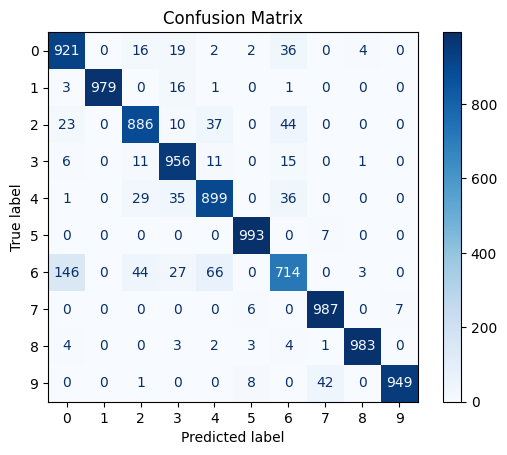

In [9]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)


print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Final Training Accuracy: 0.9476
Final Validation Accuracy: 0.9267


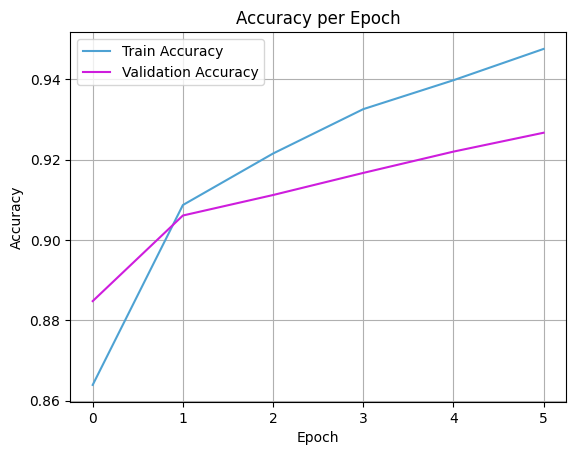

In [10]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

random squares, max_size_ratio = 0.05, max_number_of_squares = 10, label = 0.99

In [11]:
square_cutout = RandomSquaresCutout(max_size_ratio = 0.05, max_number_of_squares = 10)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor = square_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True, soft_label_fraction=0.99)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

k = Y_train.shape[1]
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [12]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
  train_generator, validation_data=test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.8113 - loss: 0.5810 - val_accuracy: 0.8653 - val_loss: 0.3800
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9048 - loss: 0.2651 - val_accuracy: 0.9074 - val_loss: 0.2689
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9094 - loss: 0.2690 - val_accuracy: 0.8670 - val_loss: 0.3742
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9007 - loss: 0.3350 - val_accuracy: 0.8620 - val_loss: 0.6888
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.8788 - loss: 0.7871 - val_accuracy: 0.8561 - val_loss: 1.0714
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8632 - loss: 2.1406 - val_accuracy: 0.8445 - val_loss: 1.6420


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

           0       0.69      0.89      0.78      1000
           1       1.00      0.95      0.97      1000
           2       0.73      0.74      0.73      1000
           3       0.83      0.88      0.85      1000
           4       0.67      0.80      0.73      1000
           5       0.98      0.96      0.97      1000
           6       0.73      0.34      0.47      1000
           7       0.94      0.95      0.95      1000
           8       0.95      0.97      0.96      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



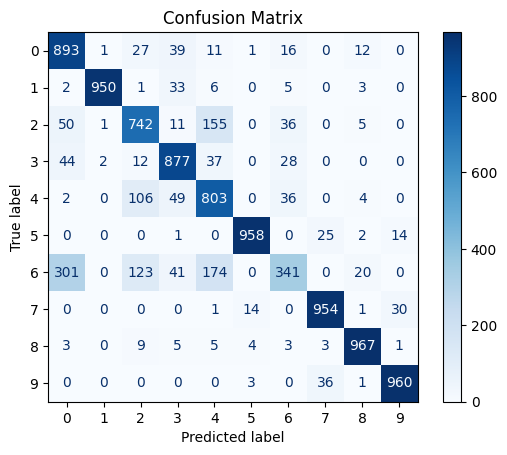

In [13]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)


print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Final Training Accuracy: 0.8548
Final Validation Accuracy: 0.8445


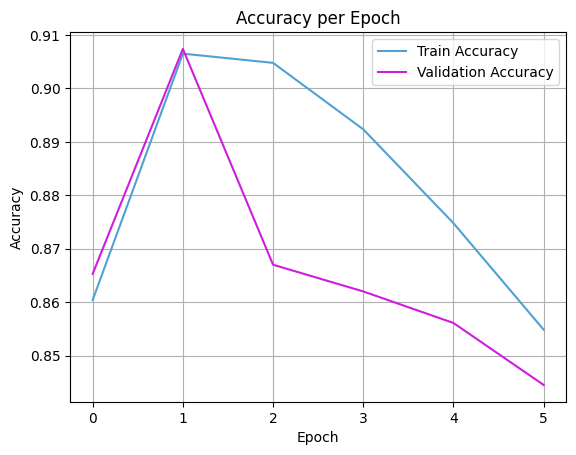

In [14]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

random pixels, soft, max_cutout_size=0.5, color=False, labels:0.9999

In [23]:
pixel_cutout = RandomPixelCutout(max_cutout_size=0.05, color=False)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=pixel_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True, soft_label_fraction=0.9999)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [24]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
  train_generator, validation_data=test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.8138 - loss: 0.5759 - val_accuracy: 0.8879 - val_loss: 0.3091
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9025 - loss: 0.2645 - val_accuracy: 0.9083 - val_loss: 0.2594
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9202 - loss: 0.2218 - val_accuracy: 0.9005 - val_loss: 0.2775
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9322 - loss: 0.1830 - val_accuracy: 0.9148 - val_loss: 0.2496
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9410 - loss: 0.1604 - val_accuracy: 0.9247 - val_loss: 0.2147
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9488 - loss: 0.1367 - val_accuracy: 0.9214 - val_loss: 0.2255


In [25]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1000
           1       0.99      0.99      0.99      1000
           2       0.94      0.82      0.88      1000
           3       0.93      0.93      0.93      1000
           4       0.84      0.92      0.88      1000
           5       0.99      0.98      0.99      1000
           6       0.73      0.86      0.79      1000
           7       0.95      0.98      0.96      1000
           8       0.98      0.99      0.99      1000
           9       0.98      0.95      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.92      0.92     10000



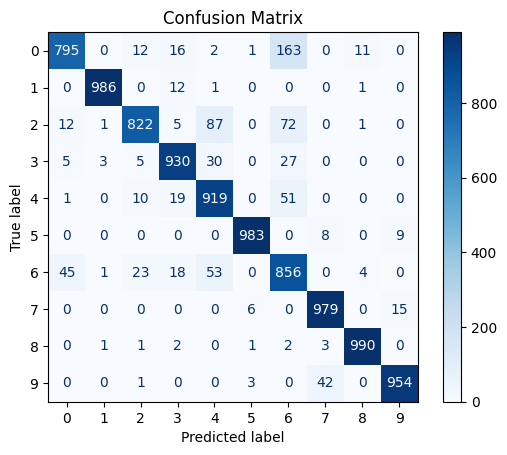

In [26]:
print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Final Training Accuracy: 0.9475
Final Validation Accuracy: 0.9214


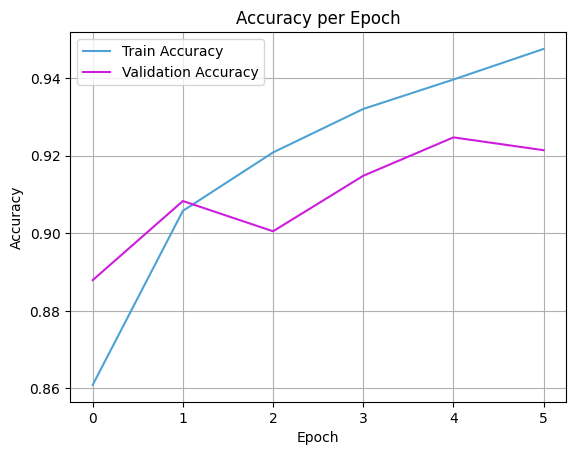

In [27]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

random pixels, soft, max_cutout_size=0.5, color=False, labels:0.999

In [28]:
pixel_cutout = RandomPixelCutout(max_cutout_size=0.05, color=False)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=pixel_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True, soft_label_fraction=0.999)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [29]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
  train_generator, validation_data=test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - accuracy: 0.8115 - loss: 0.5779 - val_accuracy: 0.8951 - val_loss: 0.2851
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9019 - loss: 0.2680 - val_accuracy: 0.9079 - val_loss: 0.2528
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9179 - loss: 0.2247 - val_accuracy: 0.9159 - val_loss: 0.2374
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9273 - loss: 0.2010 - val_accuracy: 0.9208 - val_loss: 0.2209
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9376 - loss: 0.1658 - val_accuracy: 0.9174 - val_loss: 0.2259
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9485 - loss: 0.1398 - val_accuracy: 0.9226 - val_loss: 0.2196


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.93      0.86      0.89      1000
           3       0.93      0.94      0.94      1000
           4       0.86      0.89      0.88      1000
           5       0.99      0.98      0.98      1000
           6       0.73      0.83      0.78      1000
           7       0.94      0.98      0.96      1000
           8       1.00      0.97      0.98      1000
           9       0.98      0.95      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.92      0.92     10000



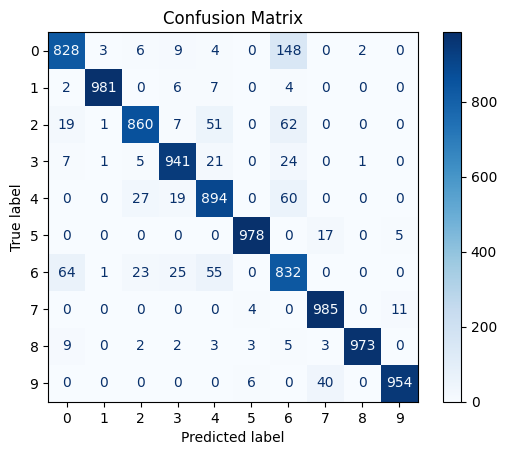

In [30]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)


print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Final Training Accuracy: 0.9460
Final Validation Accuracy: 0.9226


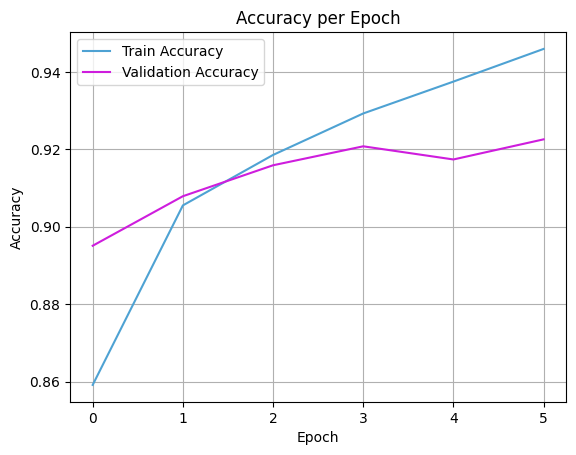

In [31]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

random pixels, soft, max_cutout_size=0.5, color=False, labels:0.99

In [32]:
pixel_cutout = RandomPixelCutout(max_cutout_size=0.05, color=False)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=pixel_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True, soft_label_fraction=0.99)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [33]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
  train_generator, validation_data=test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.8150 - loss: 0.5775 - val_accuracy: 0.8912 - val_loss: 0.3025
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.8989 - loss: 0.2746 - val_accuracy: 0.8964 - val_loss: 0.2965
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9083 - loss: 0.2635 - val_accuracy: 0.9003 - val_loss: 0.3350
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8895 - loss: 0.3946 - val_accuracy: 0.8746 - val_loss: 0.3866
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8748 - loss: 0.6612 - val_accuracy: 0.8836 - val_loss: 0.4443
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.8473 - loss: 2.7345 - val_accuracy: 0.8349 - val_loss: 0.6777


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

           0       0.84      0.72      0.78      1000
           1       0.97      0.96      0.97      1000
           2       0.67      0.81      0.73      1000
           3       0.83      0.86      0.85      1000
           4       0.73      0.62      0.67      1000
           5       0.98      0.93      0.95      1000
           6       0.56      0.61      0.59      1000
           7       0.92      0.94      0.93      1000
           8       0.97      0.93      0.95      1000
           9       0.92      0.96      0.94      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.84     10000
weighted avg       0.84      0.83      0.84     10000



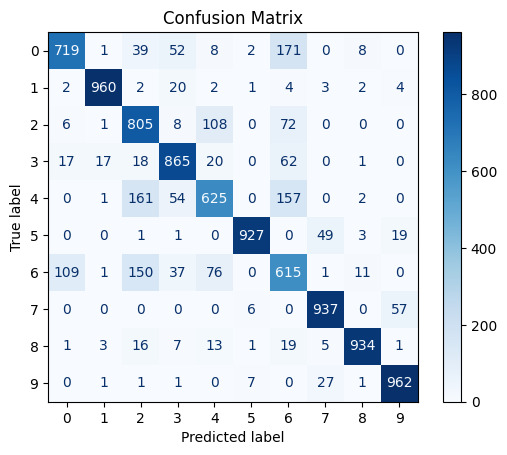

In [34]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)


print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Final Training Accuracy: 0.8355
Final Validation Accuracy: 0.8349


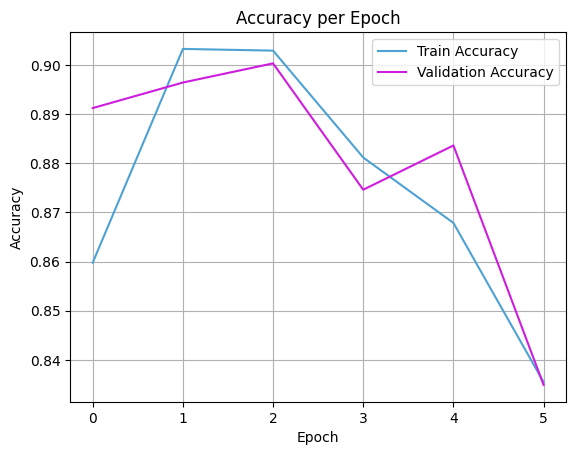

In [35]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

square cutout, size = 5, labels = 0.9999

In [23]:

square = SquareCutout(size=5, color=False)
train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=square, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True, soft_label_fraction=0.9999)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [24]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
  train_generator, validation_data=test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.8163 - loss: 0.5681 - val_accuracy: 0.8997 - val_loss: 0.2746
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - accuracy: 0.9032 - loss: 0.2592 - val_accuracy: 0.9038 - val_loss: 0.2553
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9221 - loss: 0.2125 - val_accuracy: 0.9212 - val_loss: 0.2203
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9344 - loss: 0.1795 - val_accuracy: 0.9115 - val_loss: 0.2464
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9453 - loss: 0.1546 - val_accuracy: 0.9210 - val_loss: 0.2279
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9511 - loss: 0.1332 - val_accuracy: 0.9262 - val_loss: 0.2154


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1000
           1       1.00      0.99      0.99      1000
           2       0.88      0.90      0.89      1000
           3       0.90      0.94      0.92      1000
           4       0.92      0.85      0.89      1000
           5       0.99      0.98      0.98      1000
           6       0.77      0.80      0.78      1000
           7       0.96      0.97      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



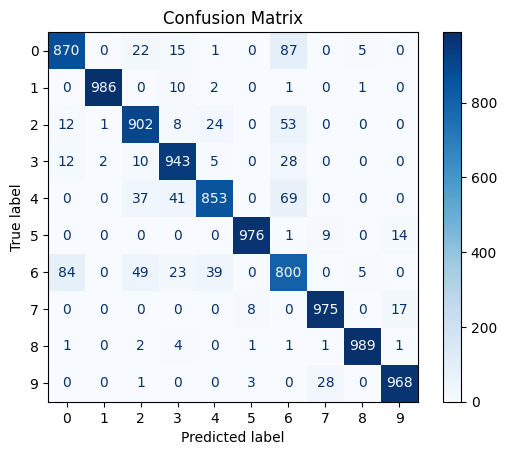

In [25]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)


print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Final Training Accuracy: 0.9505
Final Validation Accuracy: 0.9262


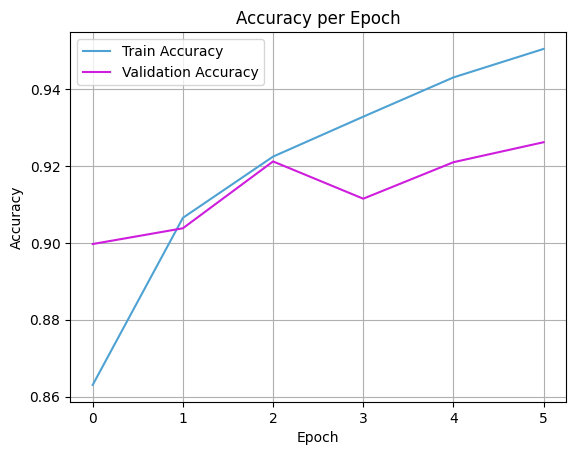

In [26]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

square cutout, size = 5, labels = 0.999

In [15]:

square = SquareCutout(size=5, color=False)
train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=square, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True, soft_label_fraction=0.999)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [16]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
  train_generator, validation_data=test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - accuracy: 0.8104 - loss: 0.5954 - val_accuracy: 0.8736 - val_loss: 0.3523
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9028 - loss: 0.2648 - val_accuracy: 0.9008 - val_loss: 0.2625
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9207 - loss: 0.2156 - val_accuracy: 0.9079 - val_loss: 0.2548
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.9330 - loss: 0.1867 - val_accuracy: 0.9199 - val_loss: 0.2202
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9404 - loss: 0.1609 - val_accuracy: 0.9254 - val_loss: 0.2089
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.9525 - loss: 0.1291 - val_accuracy: 0.9267 - val_loss: 0.2116


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      1000
           1       0.99      0.99      0.99      1000
           2       0.87      0.91      0.88      1000
           3       0.94      0.94      0.94      1000
           4       0.89      0.89      0.89      1000
           5       0.99      0.98      0.99      1000
           6       0.77      0.79      0.78      1000
           7       0.95      0.99      0.97      1000
           8       0.98      0.99      0.99      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



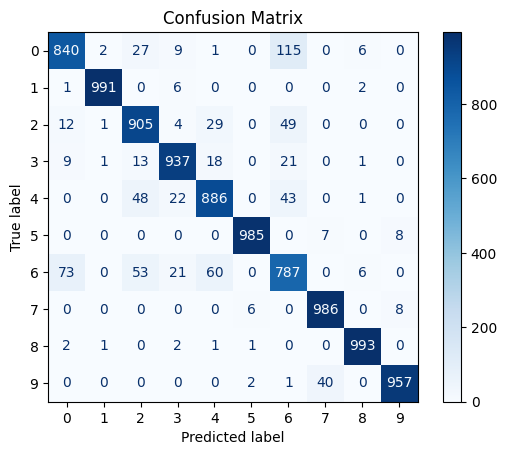

In [17]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)


print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Final Training Accuracy: 0.9491
Final Validation Accuracy: 0.9267


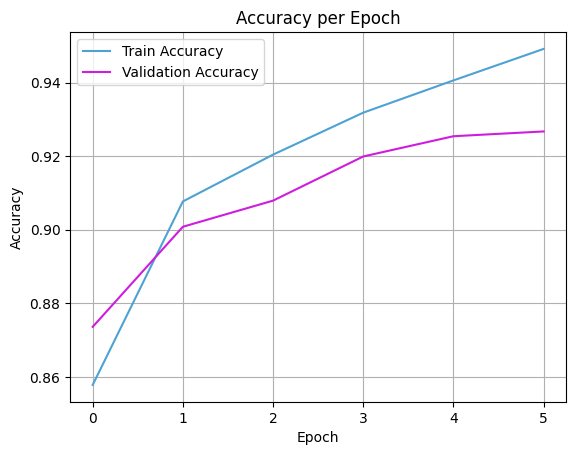

In [18]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

square cutout, size = 5, labels = 0.99

In [19]:

square = SquareCutout(size=5, color=False)
train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=square, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True, soft_label_fraction=0.99)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [20]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
  train_generator, validation_data=test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.8116 - loss: 0.5915 - val_accuracy: 0.8908 - val_loss: 0.3118
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9047 - loss: 0.2653 - val_accuracy: 0.9073 - val_loss: 0.2696
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9062 - loss: 0.2849 - val_accuracy: 0.9000 - val_loss: 0.2996
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.8875 - loss: 0.4329 - val_accuracy: 0.8005 - val_loss: 1.0891
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8718 - loss: 0.7378 - val_accuracy: 0.8446 - val_loss: 0.5781
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.8667 - loss: 1.5364 - val_accuracy: 0.8494 - val_loss: 0.9855


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

           0       0.78      0.81      0.80      1000
           1       0.99      0.96      0.98      1000
           2       0.73      0.75      0.74      1000
           3       0.87      0.89      0.88      1000
           4       0.75      0.69      0.72      1000
           5       0.97      0.95      0.96      1000
           6       0.57      0.62      0.60      1000
           7       0.90      0.97      0.93      1000
           8       0.98      0.94      0.96      1000
           9       0.97      0.92      0.95      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



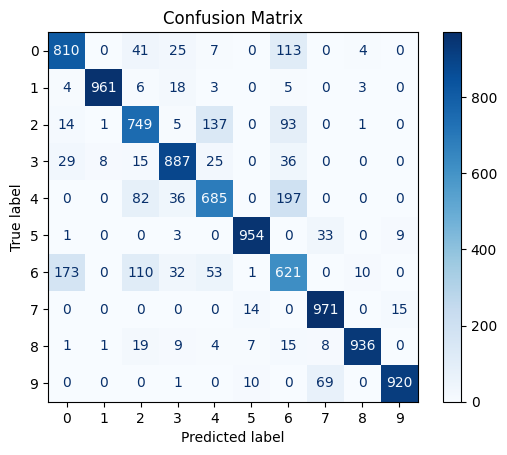

In [21]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)


print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Final Training Accuracy: 0.8568
Final Validation Accuracy: 0.8494


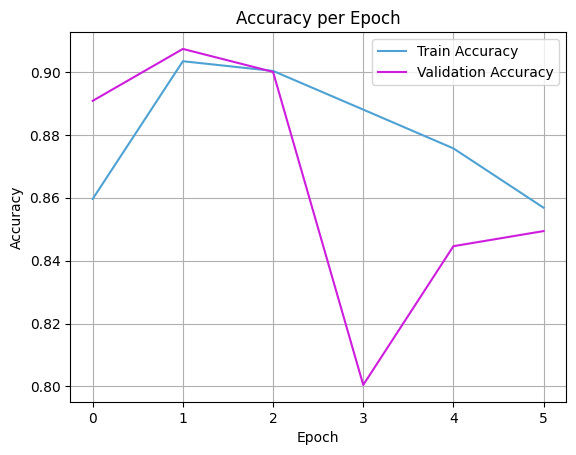

In [22]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

polygon, soft, max_size = 0.05, labels: 0.9999

In [ ]:
polygon_cutout = PolygonCutout(max_size_ratio=0.05, random_color=True)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=polygon_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True, soft_label_fraction=0.9999)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

In [ ]:
k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
 train_generator, validation_data = test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 556s 243ms/step - accuracy: 0.8073 - loss: 0.5924 - val_accuracy: 0.8888 - val_loss: 0.3029
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 542s 241ms/step - accuracy: 0.9030 - loss: 0.2662 - val_accuracy: 0.9050 - val_loss: 0.2599
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 562s 241ms/step - accuracy: 0.9219 - loss: 0.2142 - val_accuracy: 0.9115 - val_loss: 0.2423
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 539s 240ms/step - accuracy: 0.9293 - loss: 0.1910 - val_accuracy: 0.9216 - val_loss: 0.2315
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 565s 241ms/step - accuracy: 0.9431 - loss: 0.1553 - val_accuracy: 0.9209 - val_loss: 0.2243
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 542s 241ms/step - accuracy: 0.9486 - loss: 0.1382 - val_accuracy: 0.9232 - val_loss: 0.2222


In [ ]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step


              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1000
           1       1.00      0.98      0.99      1000
           2       0.84      0.93      0.88      1000
           3       0.93      0.94      0.93      1000
           4       0.85      0.91      0.88      1000
           5       0.99      0.98      0.99      1000
           6       0.85      0.69      0.77      1000
           7       0.93      0.99      0.96      1000
           8       0.99      0.98      0.98      1000
           9       0.99      0.94      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



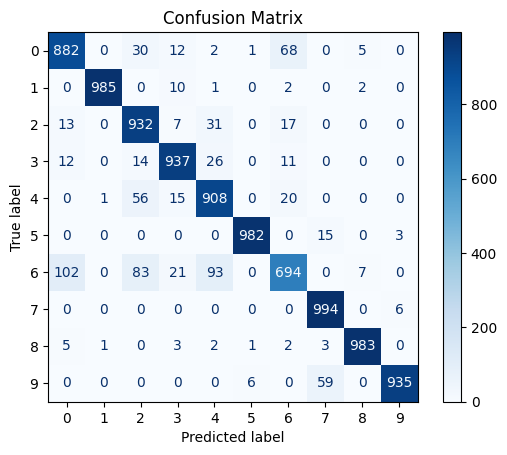

In [ ]:
print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Final Training Accuracy: 0.9481
Final Validation Accuracy: 0.9232


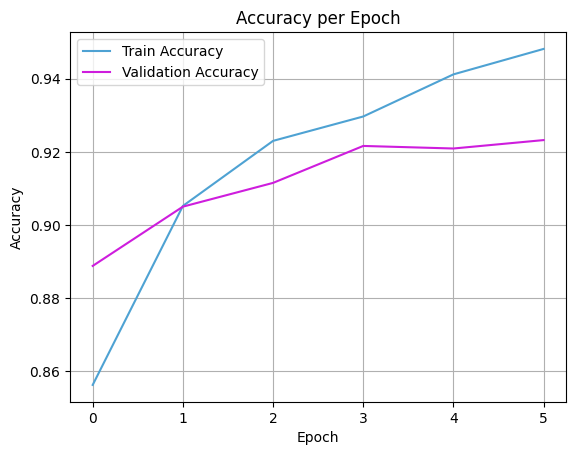

In [ ]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

polygon, soft, max_size = 0.05, labels: 0.999

In [36]:
polygon_cutout = PolygonCutout(max_size_ratio=0.05, random_color=True)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=polygon_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True, soft_label_fraction=0.999)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [37]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
 train_generator, validation_data = test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.8071 - loss: 0.6063 - val_accuracy: 0.8701 - val_loss: 0.3561
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - accuracy: 0.9025 - loss: 0.2673 - val_accuracy: 0.9021 - val_loss: 0.2745
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9197 - loss: 0.2220 - val_accuracy: 0.9021 - val_loss: 0.2686
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9322 - loss: 0.1853 - val_accuracy: 0.9184 - val_loss: 0.2270
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9395 - loss: 0.1677 - val_accuracy: 0.9275 - val_loss: 0.2127
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9487 - loss: 0.1397 - val_accuracy: 0.9033 - val_loss: 0.3064


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
              precision    recall  f1-score   support

           0       0.82      0.92      0.86      1000
           1       0.94      0.99      0.96      1000
           2       0.83      0.88      0.85      1000
           3       0.92      0.93      0.92      1000
           4       0.90      0.78      0.84      1000
           5       0.99      0.95      0.97      1000
           6       0.76      0.71      0.73      1000
           7       0.91      0.99      0.95      1000
           8       0.99      0.95      0.97      1000
           9       0.99      0.94      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



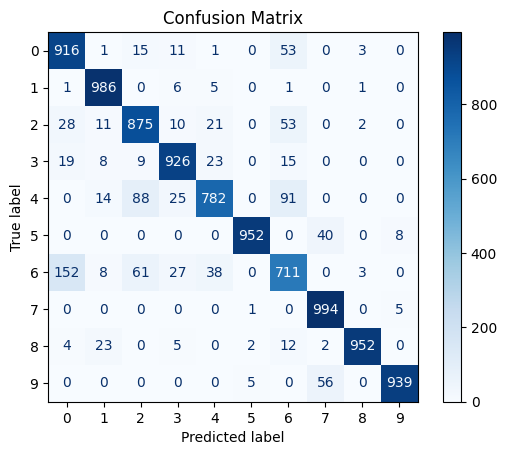

In [38]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)


print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Final Training Accuracy: 0.9479
Final Validation Accuracy: 0.9033


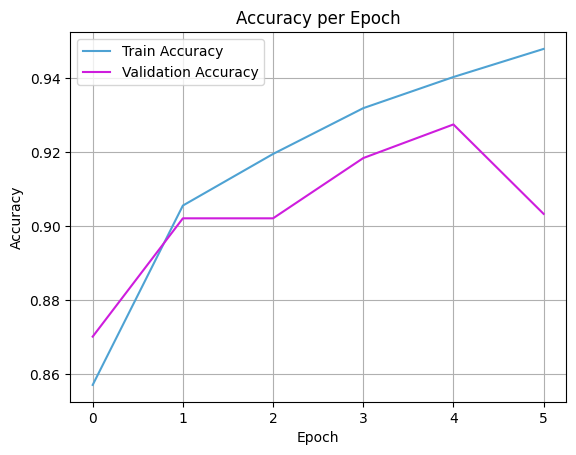

In [39]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

polygon, soft, max_size = 0.05, labels: 0.99

In [40]:
polygon_cutout = PolygonCutout(max_size_ratio=0.05, random_color=True)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=polygon_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True, soft_label_fraction=0.99)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [41]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
 train_generator, validation_data = test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.8107 - loss: 0.5947 - val_accuracy: 0.8990 - val_loss: 0.2773
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9035 - loss: 0.2623 - val_accuracy: 0.8965 - val_loss: 0.2849
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9109 - loss: 0.2568 - val_accuracy: 0.9018 - val_loss: 0.3225
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8997 - loss: 0.4120 - val_accuracy: 0.8747 - val_loss: 0.5530
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8865 - loss: 0.8350 - val_accuracy: 0.8645 - val_loss: 1.4206
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.8682 - loss: 1.4991 - val_accuracy: 0.8416 - val_loss: 2.2954


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1000
           1       0.99      0.95      0.97      1000
           2       0.70      0.77      0.73      1000
           3       0.85      0.85      0.85      1000
           4       0.65      0.87      0.74      1000
           5       0.97      0.95      0.96      1000
           6       0.67      0.43      0.52      1000
           7       0.94      0.92      0.93      1000
           8       0.96      0.95      0.95      1000
           9       0.91      0.96      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



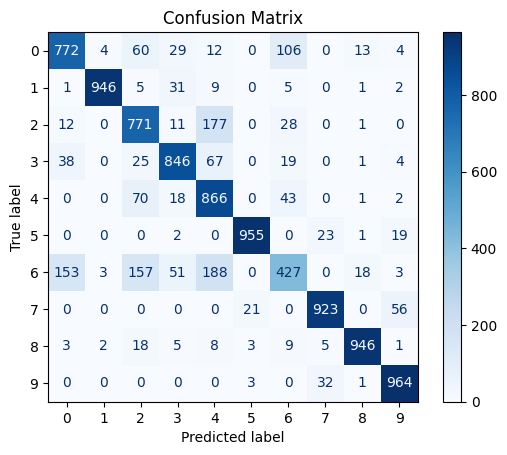

In [42]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)


print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Final Training Accuracy: 0.8582
Final Validation Accuracy: 0.8416


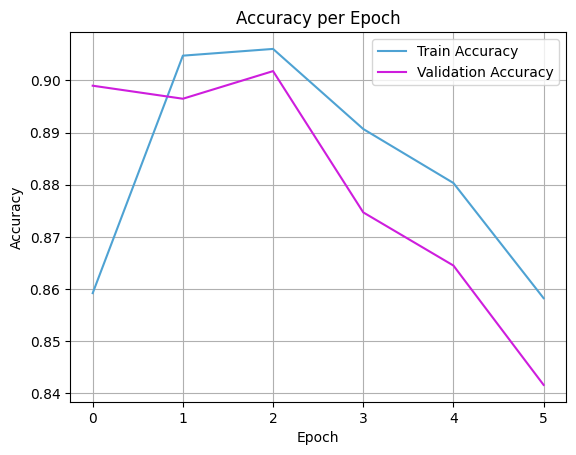

In [43]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

###cifar10
load data

In [ ]:
cifar10 = tf.keras.datasets.cifar10

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(f"X_train.shape: {X_train.shape} \nY_train.shape: {Y_train.shape} \nX_test.shape: {X_test.shape} \nY_test.shape: {Y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
X_train.shape: (50000, 32, 32, 3) 
Y_train.shape: (50000, 1) 
X_test.shape: (10000, 32, 32, 3) 
Y_test.shape: (10000, 1)


random square, max_number = 10, ratio = 0.05

In [ ]:
random_squares = RandomSquaresCutout(max_number_of_squares=10, max_size_ratio=0.05)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=random_squares, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True, soft_label_fraction = 0.9999)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

In [ ]:
k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
 train_generator, validation_data = test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.4601 - loss: 1.7007 - val_accuracy: 0.5780 - val_loss: 1.2748
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7051 - loss: 0.8549 - val_accuracy: 0.6988 - val_loss: 0.8574
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.7686 - loss: 0.6734 - val_accuracy: 0.7462 - val_loss: 0.7922
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8161 - loss: 0.5422 - val_accuracy: 0.7933 - val_loss: 0.6231
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.8460 - loss: 0.4502 - val_accuracy: 0.7775 - val_loss: 0.6706
Epoch 6/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.8733 - loss: 0.3702 - val_accuracy: 0.7826 - val_loss: 0.7553


In [ ]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose = 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


              precision    recall  f1-score   support

           0       0.87      0.76      0.81      1000
           1       0.93      0.87      0.90      1000
           2       0.74      0.65      0.69      1000
           3       0.63      0.62      0.63      1000
           4       0.71      0.80      0.75      1000
           5       0.61      0.80      0.69      1000
           6       0.74      0.92      0.82      1000
           7       0.95      0.68      0.79      1000
           8       0.88      0.89      0.88      1000
           9       0.90      0.84      0.87      1000

    accuracy                           0.78     10000
   macro avg       0.80      0.78      0.78     10000
weighted avg       0.80      0.78      0.78     10000



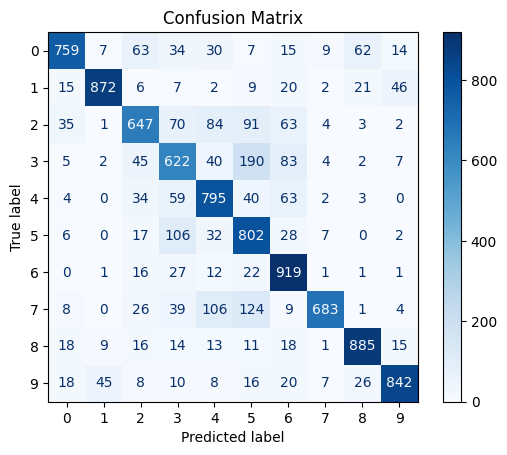

In [ ]:
print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Final Training Accuracy: 0.8687
Final Validation Accuracy: 0.7826


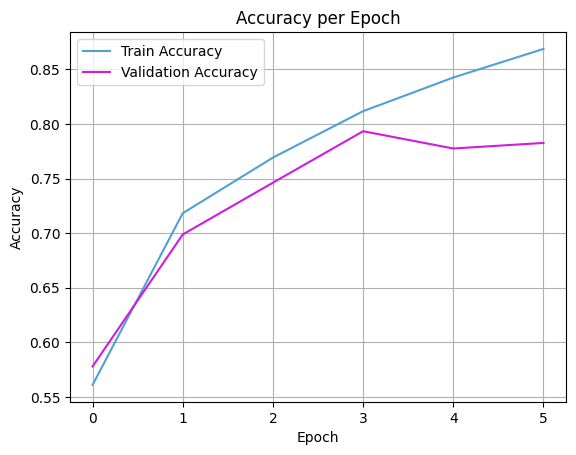

In [ ]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()